In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import LlavaForConditionalGeneration
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
from transformers import GenerationConfig
from PIL import Image

/home/hongong/anaconda3/envs/image-text-vqa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **2. Read dataset**

In [2]:
# load train data
train_data = []
train_set_path = 'vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

# load val data
val_data = []
val_set_path = 'vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

# load test data
test_data = []
test_set_path = 'vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

        

## **3. Create VQA model**

In [3]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "llava-hf/llava-1.5-7b-hf"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id,
                                                      quantization_config=quantization_config,
                                                      device_map=device)

Using cuda device


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


## **4. Create prompt**

In [4]:
def create_prompt(question):
    prompt = f"""
    ### INSTRUCTION:
    Your task is to answer the question based on the given image. You can only answer "yes" or "no".

    ### USER: <image>
    {question}
    
    ### ASSISTANT:
    """

    return prompt

In [5]:
question = "what is this about?"
create_prompt(question)

'\n    ### INSTRUCTION:\n    Your task is to answer the question based on the given image. You can only answer "yes" or "no".\n\n    ### USER: <image>\n    what is this about?\n    \n    ### ASSISTANT:\n    '

## **5. Inference**

In [6]:
generation_config = GenerationConfig(
    max_new_tokens=10,
    do_sample=True,
    temperature=0.1,
    top_p=0.95,
    top_k=50,
    eos_token_id=model.config.eos_token_id,
    pad_token=model.config.pad_token_id,
)

You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transformers v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


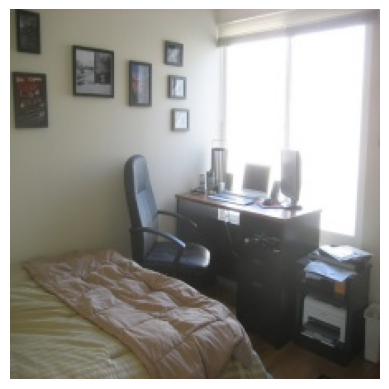

Question: Are there any boxes in the room ?
Label: no
Prediction: 
    
    No


In [7]:
idx = 0
question = test_data[idx]['question']
image_name = test_data[idx]['image_path']
image_path = os.path.join('val2014-resised', image_name)
label = test_data[idx]['answer']
image = Image.open(image_path)

prompt = create_prompt(question)
inputs = processor(prompt,
                   image,
                   padding=True,
                   return_tensors="pt").to(device)

output = model.generate(**inputs,
                        generation_config=generation_config)
generated_text = processor.decode(output[0],
                                  skip_special_tokens=True)

plt.imshow(image)
plt.axis("off")
plt.show()
print(f"Question: {question}")
print(f"Label: {label}")
print(f"Prediction: {generated_text.split('### ASSISTANT:')[-1]}")

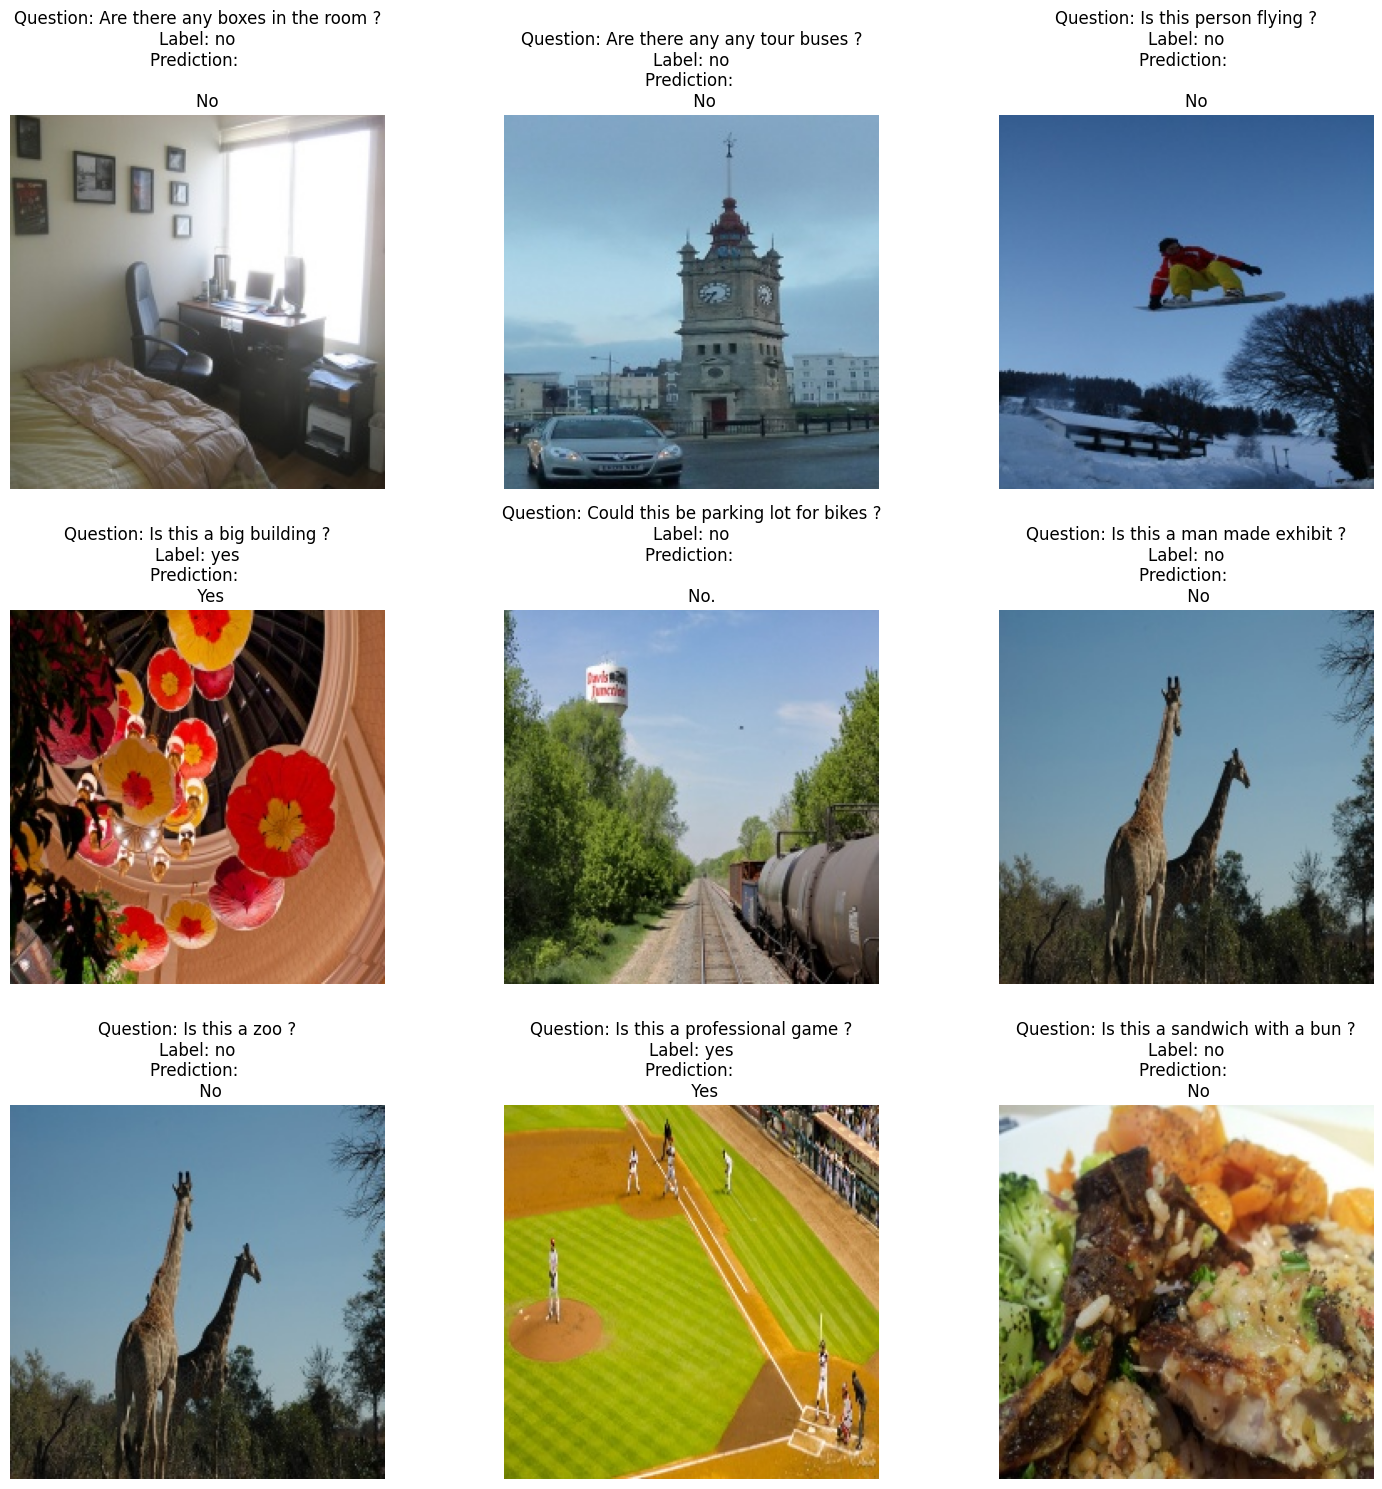

In [10]:
# sample list of questions and plot the image given idx value
# plot figure 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for idx, ax in enumerate(axes):
    question = test_data[idx]['question']
    image_name = test_data[idx]['image_path']
    image_path = os.path.join('val2014-resised', image_name)
    label = test_data[idx]['answer']
    image = Image.open(image_path)

    prompt = create_prompt(question)
    inputs = processor(prompt,
                       image,
                       padding=True,
                       return_tensors="pt").to(device)

    output = model.generate(**inputs,
                            generation_config=generation_config)
    generated_text = processor.decode(output[0],
                                      skip_special_tokens=True)

    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Question: {question}\nLabel: {label}\nPrediction: {generated_text.split('### ASSISTANT:')[-1]}")

plt.tight_layout()
plt.show()